# PROJETO IA - DETECÇÃO DE DOENÇAS EM PLANTAS

**Alunos:** Rilson Joás e Ryan Eskinazi

### Setup e Verificação do Ambiente
Esta seção contém as importações principais e uma verificação para saber se o TensorFlow está utilizando a CPU ou uma GPU. Execute esta célula primeiro para garantir que seu ambiente está configurado corretamente.

In [1]:
import tensorflow as tf

print("Versão do TensorFlow:", tf.__version__)
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"\nSUCESSO: {len(gpus)} GPU(s) encontradas e configuradas!")
        print(f"Detalhes: {gpus[0]}")
    except RuntimeError as e:
        print(e)
else:
    print(
        "\nAVISO: Nenhuma GPU foi encontrada. O treinamento da CNN será feito na CPU e pode ser lento."
    )

2025-07-16 18:49:18.551376: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-16 18:49:18.629173: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-16 18:49:18.668131: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752702558.739573    2520 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752702558.753560    2520 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752702558.901916    2520 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Versão do TensorFlow: 2.19.0

AVISO: Nenhuma GPU foi encontrada. O treinamento da CNN será feito na CPU e pode ser lento.


2025-07-16 18:49:28.739976: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## PARTE 1: Extração de Características para Algoritmos Clássicos
Nesta seção, vamos processar as imagens para gerar dois datasets em formato `.csv`:
1.  **Base \"Bruta\"**: Contendo apenas características de cor.
2.  **Base \"Pré-Processada\"**: Contendo características de cor e de textura.  

Os arquivos `.csv` gerados são salvos em uma nova pasta chamada `dados_gerados/`.

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
from tqdm.auto import tqdm

print("Bibliotecas para extração de características importadas com sucesso.")

def extrair_caracteristicas_v2(caminho_imagem, tipo_extracao="completa"):
    try:
        imagem = cv2.imread(caminho_imagem)
        imagem = cv2.resize(imagem, (128, 128))

        hist_cor = cv2.calcHist(
            [imagem], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256]
        )
        cv2.normalize(hist_cor, hist_cor)
        hist_cor = hist_cor.flatten()

        if tipo_extracao == "simples":
            return hist_cor

        cinza = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
        glcm = graycomatrix(
            cinza, distances=[5], angles=[0], levels=256, symmetric=True, normed=True
        )
        contraste = graycoprops(glcm, "contrast")[0, 0]
        dissimilaridade = graycoprops(glcm, "dissimilarity")[0, 0]
        homogeneidade = graycoprops(glcm, "homogeneity")[0, 0]
        energia = graycoprops(glcm, "energy")[0, 0]
        correlacao = graycoprops(glcm, "correlation")[0, 0]
        caracteristicas_textura = np.array(
            [contraste, dissimilaridade, homogeneidade, energia, correlacao]
        )

        return np.hstack([hist_cor, caracteristicas_textura])
    except Exception as e:
        print(f"Erro ao processar {caminho_imagem}: {e}")
        return None


def criar_dataset_csv_v2(diretorio_base, caminho_saida_csv, tipo_extracao):
    print(f"\nIniciando processamento '{tipo_extracao}' para: {diretorio_base}")
    diretorio_treino = os.path.join(diretorio_base, "train")
    if not os.path.isdir(diretorio_treino):
        print(
            f"ERRO: Diretório de treino não encontrado em '{diretorio_treino}'. Verifique o caminho."
        )
        return

    classes = sorted(os.listdir(diretorio_treino))
    lista_de_features = []
    lista_de_labels = []

    for nome_classe in tqdm(classes, desc=f"Processando ({tipo_extracao})"):
        caminho_classe = os.path.join(diretorio_treino, nome_classe)
        if os.path.isdir(caminho_classe):
            for nome_imagem in os.listdir(caminho_classe):
                caminho_imagem = os.path.join(caminho_classe, nome_imagem)
                features = extrair_caracteristicas_v2(caminho_imagem, tipo_extracao)
                if features is not None:
                    lista_de_features.append(features)
                    lista_de_labels.append(nome_classe)

    df = pd.DataFrame(lista_de_features)
    df["label"] = lista_de_labels

    os.makedirs(os.path.dirname(caminho_saida_csv), exist_ok=True)
    df.to_csv(caminho_saida_csv, index=False)
    print(f"Dataset '{tipo_extracao}' salvo com sucesso em: {caminho_saida_csv}")
    print(f"Dimensões: {df.shape[0]} amostras, {df.shape[1]} colunas")


# Definição dos caminhos locais
base_aumentada_path = "datasets/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"

# Arquivos de saída serão salvos em uma nova pasta 'dados_gerados'
output_bruto_csv = "dados_gerados/features_bruto_cor.csv"
output_processado_csv = "dados_gerados/features_processado_cor_textura.csv"

# Execução do Processamento
criar_dataset_csv_v2(base_aumentada_path, output_bruto_csv, tipo_extracao="simples")
criar_dataset_csv_v2(
    base_aumentada_path, output_processado_csv, tipo_extracao="completa"
)

print("\n--- FIM DA EXTRAÇÃO DE CARACTERÍSTICAS ---")

Bibliotecas para extração de características importadas com sucesso.

Iniciando processamento 'simples' para: datasets/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)


Processando (simples):   0%|          | 0/38 [00:00<?, ?it/s]

Dataset 'simples' salvo com sucesso em: dados_gerados/features_bruto_cor.csv
Dimensões: 70295 amostras, 513 colunas

Iniciando processamento 'completa' para: datasets/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)


Processando (completa):   0%|          | 0/38 [00:00<?, ?it/s]

Dataset 'completa' salvo com sucesso em: dados_gerados/features_processado_cor_textura.csv
Dimensões: 70295 amostras, 518 colunas

--- FIM DA EXTRAÇÃO DE CARACTERÍSTICAS ---


## PARTE 2: Treinamento com Rede Neural Convolucional (CNN)
Agora, vamos configurar, treinar e avaliar a CNN.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    InputLayer,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Constantes do Modelo e Treinamento
IMG_SIZE = (
    128,
    128,
)  # O tamanho foi reduzido para 128x128 para um treino mais rápido em uma CPU/GPU local. O Google Colab pode suportar tamanhos maiores, mas ele dá um limite. 
BATCH_SIZE = 32
EPOCHS = 20  

# Caminhos Locais
BASE_DATA_DIR = "datasets/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
TRAIN_DIR = os.path.join(BASE_DATA_DIR, "train")
VALID_DIR = os.path.join(BASE_DATA_DIR, "valid")

print("Configurando os geradores de dados...")

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
)

validation_generator = validation_datagen.flow_from_directory(
    VALID_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
)

num_classes = len(train_generator.class_indices)
print(
    f"\nEncontradas {train_generator.samples} imagens de treino pertencentes a {num_classes} classes."
)
print(f"Encontradas {validation_generator.samples} imagens de validação.")


Configurando os geradores de dados...
Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.

Encontradas 70295 imagens de treino pertencentes a 38 classes.
Encontradas 17572 imagens de validação.


In [4]:
print("Construindo o modelo CNN...")

model = Sequential(
    [
        InputLayer(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        Conv2D(32, (3, 3), activation="relu", padding="same"),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation="relu", padding="same"),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation="relu", padding="same"),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation="relu", padding="same"),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation="softmax"),
    ]
)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()


Construindo o modelo CNN...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │        19,494 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,800,998 (33.57 MB)

 Trainable params: 8,799,014 (33.57 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [5]:
print("Iniciando o treinamento da CNN...")

history = model.fit(
    train_generator, epochs=EPOCHS, validation_data=validation_generator
)

print("--- Treinamento Concluído! ---")

Iniciando o treinamento da CNN...


/home/rilson/.conda/envs/projeto_ia/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 3401s 2s/step - accuracy: 0.5237 - loss: 1.7425 - val_accuracy: 0.5005 - val_loss: 2.4140
Epoch 2/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 2933s 1s/step - accuracy: 0.8431 - loss: 0.4987 - val_accuracy: 0.7243 - val_loss: 1.3849
Epoch 3/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 2894s 1s/step - accuracy: 0.8999 - loss: 0.3099 - val_accuracy: 0.6557 - val_loss: 2.2582
Epoch 4/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 2887s 1s/step - accuracy: 0.9237 - loss: 0.2374 - val_accuracy: 0.7370 - val_loss: 1.6928
Epoch 5/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 2901s 1s/step - accuracy: 0.9353 - loss: 0.1956 - val_accuracy: 0.7219 - val_loss: 1.4567
Epoch 6/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 2941s 1s/step - accuracy: 0.9447 - loss: 0.1711 - val_accuracy: 0.8520 - val_loss: 0.8226
Epoch 7/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 3239s 1s/step - accuracy: 0.9542 - loss: 0.1432 - val_accuracy: 0.9137 - val_loss: 0.4284
Epoch 8/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 3009s 1s/step - accuracy: 0.9580 -

Gerando gráficos de performance do treinamento da CNN...


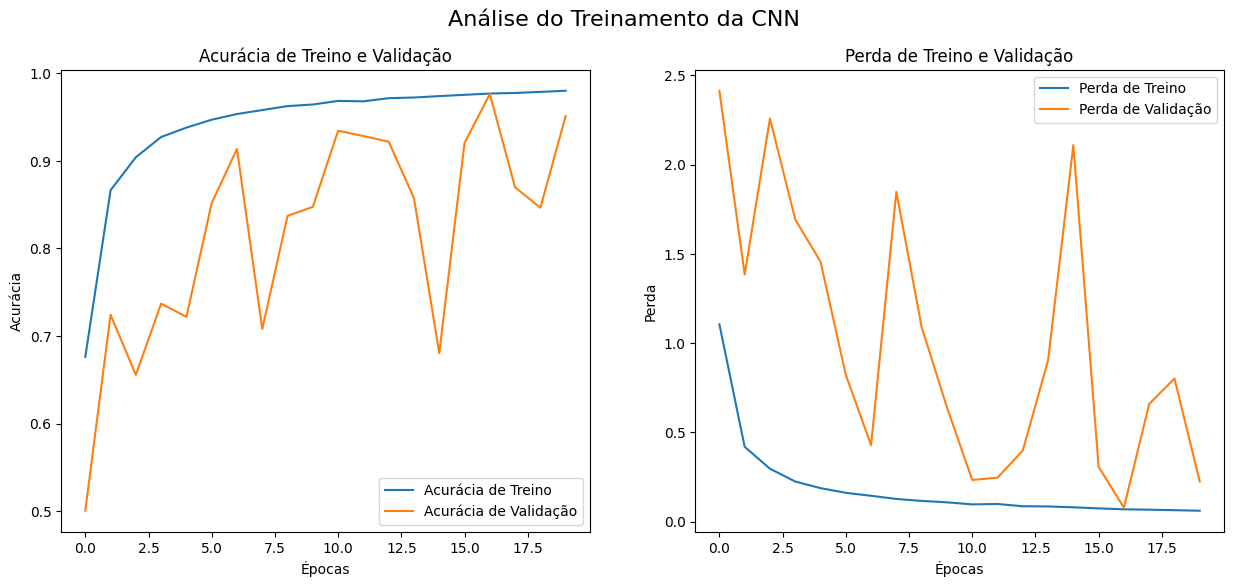

In [6]:
print("Gerando gráficos de performance do treinamento da CNN...")

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs_range = range(len(acc))

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Acurácia de Treino")
plt.plot(epochs_range, val_acc, label="Acurácia de Validação")
plt.legend(loc="lower right")
plt.title("Acurácia de Treino e Validação")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Perda de Treino")
plt.plot(epochs_range, val_loss, label="Perda de Validação")
plt.legend(loc="upper right")
plt.title("Perda de Treino e Validação")
plt.xlabel("Épocas")
plt.ylabel("Perda")

plt.suptitle("Análise do Treinamento da CNN", fontsize=16)
plt.show()


In [7]:
print("\nIniciando a avaliação final do modelo no conjunto de dados de validação...")

final_loss, final_accuracy = model.evaluate(validation_generator)

print("\n--- Resultados Finais da CNN ---")
print(f"Perda Final (Loss): {final_loss:.4f}")
print(f"Acurácia Final (Accuracy): {final_accuracy * 100:.2f}%")



Iniciando a avaliação final do modelo no conjunto de dados de validação...
550/550 ━━━━━━━━━━━━━━━━━━━━ 149s 270ms/step - accuracy: 0.9747 - loss: 0.0971

--- Resultados Finais da CNN ---
Perda Final (Loss): 0.2245
Acurácia Final (Accuracy): 95.13%


## PARTE 3: Experimentos com Algoritmos Clássicos
Agora, usaremos os arquivos `.csv` gerados para treinar e avaliar os modelos clássicos com o esquema 5x10 cross-validation.

In [ ]:
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
import time
import warnings

warnings.filterwarnings("ignore")

print("Bibliotecas do Scikit-learn importadas com sucesso.")


def carregar_e_preparar_dados(caminho_csv):
    print(f"\nCarregando dados de: {caminho_csv}")
    df = pd.read_csv(caminho_csv)
    X = df.drop("label", axis=1).values
    y_text = df["label"].values
    encoder = LabelEncoder()
    y = encoder.fit_transform(y_text)
    print(f"Dados carregados. Formato de X: {X.shape}, Formato de y: {y.shape}")
    return X, y, encoder


# Carregando os dois datasets gerados localmente
caminho_bruto = "dados_gerados/features_bruto_cor.csv"
caminho_processado = "dados_gerados/features_processado_cor_textura.csv"

X_bruto, y_bruto, label_encoder = carregar_e_preparar_dados(caminho_bruto)
X_processado, y_processado, _ = carregar_e_preparar_dados(caminho_processado)


Bibliotecas do Scikit-learn importadas com sucesso.

Carregando dados de: dados_gerados/features_bruto_cor.csv
Dados carregados. Formato de X: (70295, 512), Formato de y: (70295,)

Carregando dados de: dados_gerados/features_processado_cor_textura.csv
Dados carregados. Formato de X: (70295, 517), Formato de y: (70295,)


In [ ]:
def executar_experimentos(X, y, nome_dataset):
    print(f"\n--- Iniciando experimentos para o dataset: {nome_dataset} ---")
    modelos = {
        "Árvore de Decisão": DecisionTreeClassifier(random_state=42),
        "Naive Bayes": GaussianNB(),
        "KNN (k=3)": KNeighborsClassifier(n_neighbors=3),
        "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),
        "KNN (k=7)": KNeighborsClassifier(n_neighbors=7),
    }

    rkf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)
    todos_os_resultados = []

    for i, (train_index, test_index) in tqdm(
        enumerate(rkf.split(X, y)), total=50, desc=f"Executando {nome_dataset}"
    ):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        for nome_modelo, modelo in modelos.items():
            start_time = time.time()
            modelo.fit(X_train, y_train)
            y_pred = modelo.predict(X_test)
            end_time = time.time()
            tempo_execucao = end_time - start_time
            acuracia = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average="weighted")

            todos_os_resultados.append(
                {
                    "dataset": nome_dataset,
                    "repeticao": (i // 10) + 1,
                    "fold": (i % 10) + 1,
                    "algoritmo": nome_modelo,
                    "acuracia": acuracia,
                    "f1_score_ponderado": f1,
                    "tempo_execucao": tempo_execucao,
                }
            )

    print(f"--- Experimentos para o dataset {nome_dataset} concluídos! ---")
    return pd.DataFrame(todos_os_resultados)


# Rodando os experimentos para ambos os datasets
resultados_bruto = executar_experimentos(X_bruto, y_bruto, "Bruto (Cor)")
resultados_processado = executar_experimentos(
    X_processado, y_processado, "Processado (Cor+Textura)"
)

# Concatenamos todos os resultados em um único DataFrame para análise
resultados_finais_classicos = pd.concat(
    [resultados_bruto, resultados_processado], ignore_index=True
)

print("\n\nTODOS OS EXPERIMENTOS CLÁSSICOS FORAM CONCLUÍDOS!")


--- Iniciando experimentos para o dataset: Bruto (Cor) ---


Executando Bruto (Cor):   0%|          | 0/50 [00:00<?, ?it/s]

--- Experimentos para o dataset Bruto (Cor) concluídos! ---

--- Iniciando experimentos para o dataset: Processado (Cor+Textura) ---


Executando Processado (Cor+Textura):   0%|          | 0/50 [00:00<?, ?it/s]

--- Experimentos para o dataset Processado (Cor+Textura) concluídos! ---


TODOS OS EXPERIMENTOS CLÁSSICOS FORAM CONCLUÍDOS!


## PARTE 4: Análise Final e Visualização
Finalmente, vamos agregar e visualizar os resultados dos modelos clássicos.

--- Análise Estatística dos Resultados dos Algoritmos Clássicos ---
Tabela de Desempenho (Média e Desvio Padrão de 50 execuções):
                                            acuracia_media  acuracia_std  \
dataset                  algoritmo                                         
Bruto (Cor)              KNN (k=3)                  0.8852        0.0044   
                         KNN (k=5)                  0.8595        0.0043   
                         KNN (k=7)                  0.8516        0.0042   
                         Naive Bayes                0.4134        0.0061   
                         Árvore de Decisão          0.8579        0.0043   
Processado (Cor+Textura) KNN (k=3)                  0.3768        0.0054   
                         KNN (k=5)                  0.3053        0.0057   
                         KNN (k=7)                  0.2721        0.0054   
                         Naive Bayes                0.5542        0.0069   
                         Árvore de

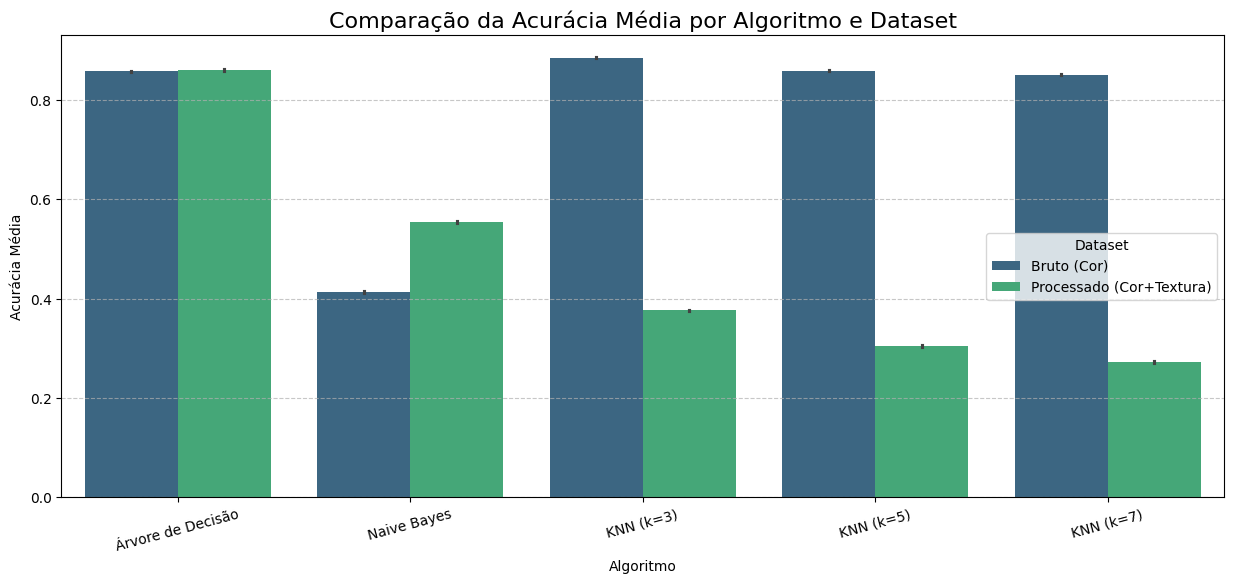

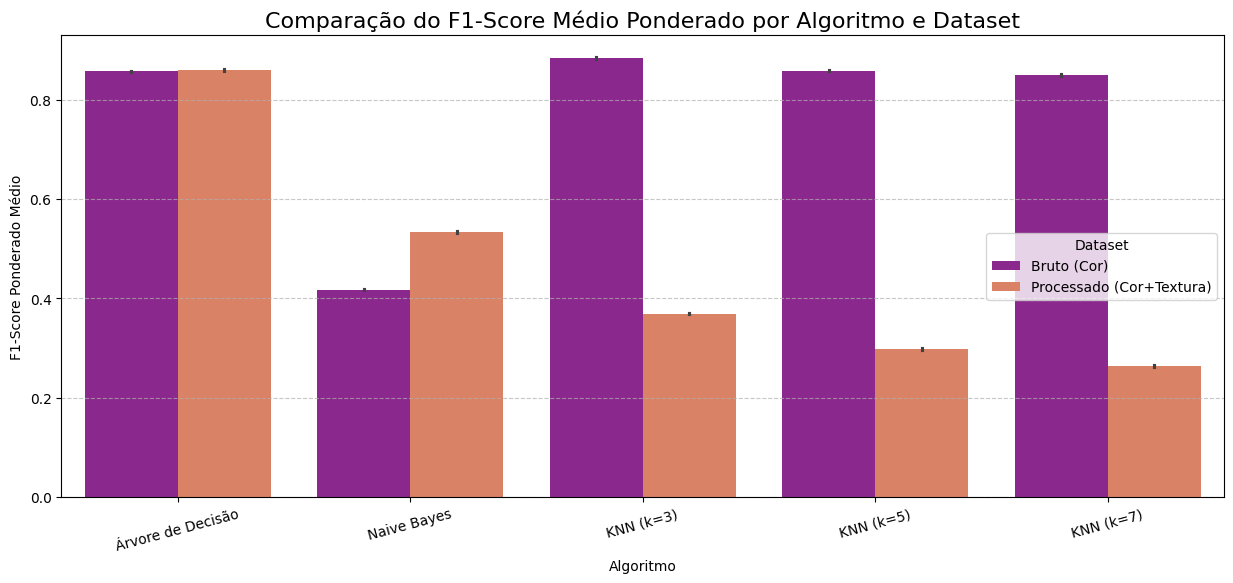

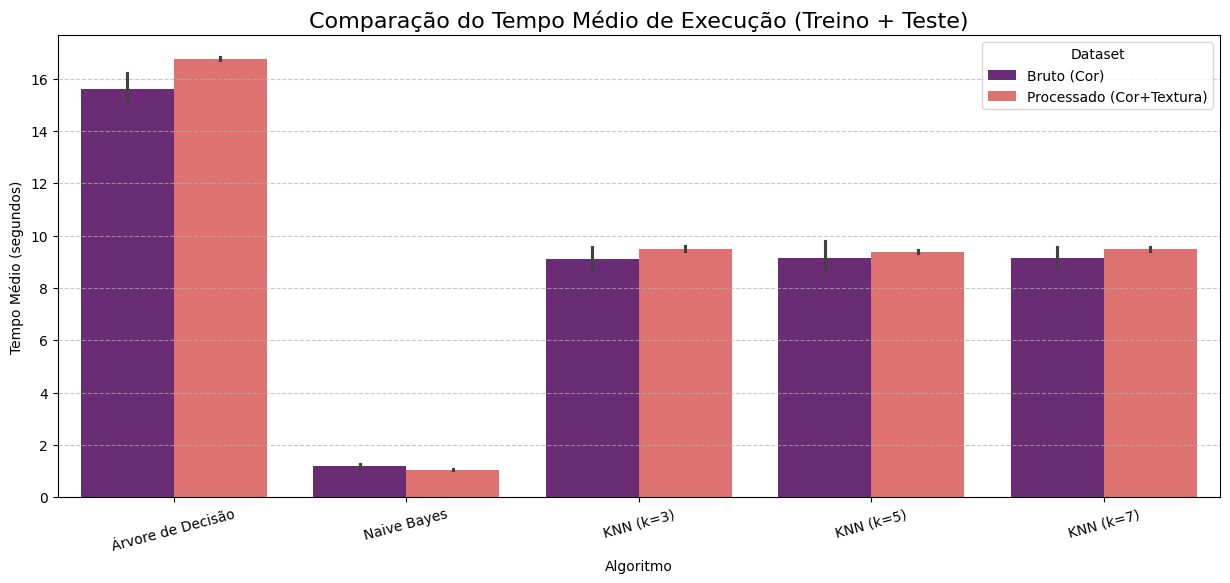

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

print("--- Análise Estatística dos Resultados dos Algoritmos Clássicos ---")

analise_agregada = (
    resultados_finais_classicos.groupby(["dataset", "algoritmo"])
    .agg(
        acuracia_media=("acuracia", "mean"),
        acuracia_std=("acuracia", "std"),
        f1_media=("f1_score_ponderado", "mean"),
        f1_std=("f1_score_ponderado", "std"),
        tempo_medio=("tempo_execucao", "mean"),
        tempo_std=("tempo_execucao", "std"),
    )
    .round(4)
)

print("Tabela de Desempenho (Média e Desvio Padrão de 50 execuções):")
print(analise_agregada)

print("\nGerando gráficos comparativos...")

plt.figure(figsize=(15, 6))
sns.barplot(
    data=resultados_finais_classicos,
    x="algoritmo",
    y="acuracia",
    hue="dataset",
    palette="viridis",
)
plt.title("Comparação da Acurácia Média por Algoritmo e Dataset", fontsize=16)
plt.ylabel("Acurácia Média")
plt.xlabel("Algoritmo")
plt.xticks(rotation=15)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Dataset")
plt.show()

plt.figure(figsize=(15, 6))
sns.barplot(
    data=resultados_finais_classicos,
    x="algoritmo",
    y="f1_score_ponderado",
    hue="dataset",
    palette="plasma",
)
plt.title("Comparação do F1-Score Médio Ponderado por Algoritmo e Dataset", fontsize=16)
plt.ylabel("F1-Score Ponderado Médio")
plt.xlabel("Algoritmo")
plt.xticks(rotation=15)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Dataset")
plt.show()

plt.figure(figsize=(15, 6))
sns.barplot(
    data=resultados_finais_classicos,
    x="algoritmo",
    y="tempo_execucao",
    hue="dataset",
    palette="magma",
)
plt.title("Comparação do Tempo Médio de Execução (Treino + Teste)", fontsize=16)
plt.ylabel("Tempo Médio (segundos)")
plt.xlabel("Algoritmo")
plt.xticks(rotation=15)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Dataset")
plt.show()


#### Gerando matriz de confusão

550/550 ━━━━━━━━━━━━━━━━━━━━ 184s 334ms/step


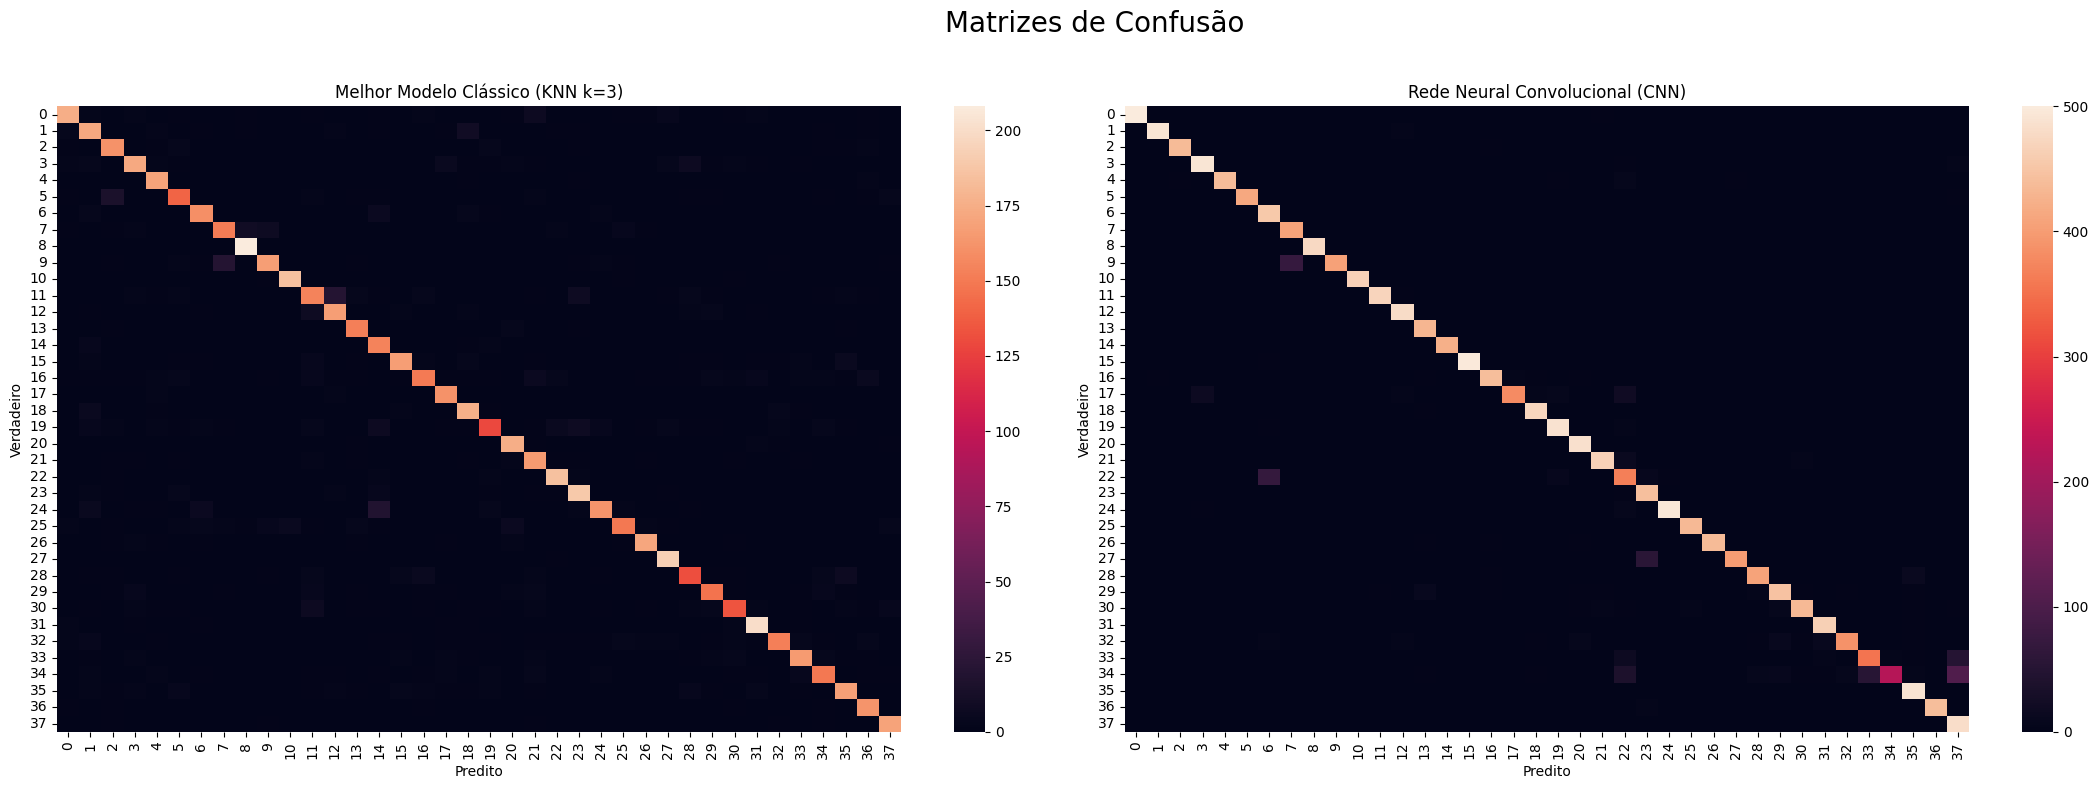

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Vamos pegar a última dobra (fold) dos dados para treinar um modelo e visualizar. Usaremos o melhor modelo clássico: KNN com k=3 na base "Bruta (Cor)"

# Preparamos os dados para um único treino/teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_bruto, y_bruto, test_size=0.1, random_state=42)

# Treinamos o melhor modelo clássico
best_classical_model = KNeighborsClassifier(n_neighbors=3)
best_classical_model.fit(X_train, y_train)
y_pred_classical = best_classical_model.predict(X_test)

# Realizamos predições com a CNN no conjunto de validação
y_pred_cnn_probs = model.predict(validation_generator)
y_pred_cnn = np.argmax(y_pred_cnn_probs, axis=1) # Converte probabilidades em classes
y_true_cnn = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())


# Plotando as Matrizes de Confusão ---
fig, axes = plt.subplots(1, 2, figsize=(22, 8))
fig.suptitle('Matrizes de Confusão', fontsize=20)

# Matriz para o Melhor Modelo Clássico (KNN k=3)
cm_classical = confusion_matrix(y_test, y_pred_classical)
sns.heatmap(cm_classical, ax=axes[0], annot=False) 
axes[0].set_title('Melhor Modelo Clássico (KNN k=3)')
axes[0].set_xlabel('Predito')
axes[0].set_ylabel('Verdadeiro')


# Matriz para a CNN
cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn)
sns.heatmap(cm_cnn, ax=axes[1], annot=False)
axes[1].set_title('Rede Neural Convolucional (CNN)')
axes[1].set_xlabel('Predito')
axes[1].set_ylabel('Verdadeiro')


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### Relatório de Classificação

In [14]:
print("--- Relatório de Classificação para o Melhor Modelo Clássico (KNN k=3) ---")
report_classical = classification_report(
    y_test, y_pred_classical, target_names=label_encoder.classes_
)
print(report_classical)


print("\n\n--- Relatório de Classificação para a CNN ---")
report_cnn = classification_report(y_true_cnn, y_pred_cnn, target_names=class_labels)
print(report_cnn)


--- Relatório de Classificação para o Melhor Modelo Clássico (KNN k=3) ---
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.92      0.86      0.89       203
                                 Apple___Black_rot       0.80      0.88      0.84       196
                          Apple___Cedar_apple_rust       0.84      0.93      0.88       174
                                   Apple___healthy       0.89      0.84      0.86       206
                               Blueberry___healthy       0.90      0.98      0.94       173
          Cherry_(including_sour)___Powdery_mildew       0.84      0.83      0.84       169
                 Cherry_(including_sour)___healthy       0.90      0.91      0.91       175
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.86      0.84      0.85       179
                       Corn_(maize)___Common_rust_       0.95      1.00      0.97       208
    

#### Importância das Características

O que características o teste com árvore de decisão se baseou mais.

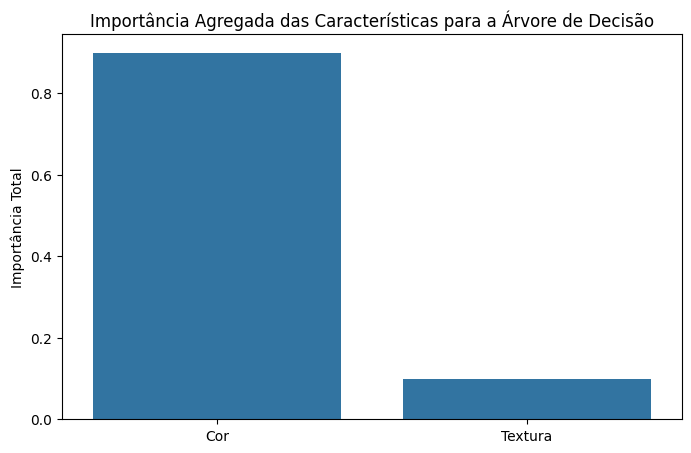

Importância total das características de Cor: 0.9002
Importância total das características de Textura: 0.0998


In [ ]:
# Treinando a árvore de decisão na base de dados completa (pré-processada com cor+textura)
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_processado, y_processado)

importances = tree_model.feature_importances_
# As primeiras 512 são de cor, as últimas 5 são de textura
importancia_cor = np.sum(importances[:512])
importancia_textura = np.sum(importances[512:])

# Plotando
plt.figure(figsize=(8, 5))
sns.barplot(x=["Cor", "Textura"], y=[importancia_cor, importancia_textura])
plt.title("Importância Agregada das Características para a Árvore de Decisão")
plt.ylabel("Importância Total")
plt.show()

print(f"Importância total das características de Cor: {importancia_cor:.4f}")
print(f"Importância total das características de Textura: {importancia_textura:.4f}")